# Model Comparison

La base de datos MNIST de dígitos escritos a mano, disponible en esta página, tiene un conjunto de entrenamiento de 60 000 ejemplos y un conjunto de prueba de 10 000 ejemplos. Es un subconjunto de un conjunto más grande disponible en NIST. Los dígitos se normalizaron en tamaño y se centraron en una imagen de tamaño fijo. Es una buena base de datos para las personas que desean probar técnicas de aprendizaje y métodos de reconocimiento de patrones en datos del mundo real mientras dedican un esfuerzo mínimo al preprocesamiento y formateo.

La base de datos MNIST de dígitos escritos a mano está disponible en el siguiente sitio web: MNIST Dataset

Hay cuatro archivos disponibles en este sitio:

train-images-idx3-ubyte.gz: training set images (9912422 bytes)
train-labels-idx1-ubyte.gz: training set labels (28881 bytes)
t10k-images-idx3-ubyte.gz: test set images (1648877 bytes)
t10k-labels-idx1-ubyte.gz: test set labels (4542 bytes)

In [ ]:
! pip install catboost

In [ ]:
# Importing packages and data
from time import time
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import (RandomForestClassifier,
                              AdaBoostClassifier,
                              GradientBoostingClassifier,
                              HistGradientBoostingClassifier)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt


## To read data
import numpy as np 
import matplotlib.pyplot as plt

# Used for Confusion Matrix
from sklearn import metrics
import seaborn as sns

# Used for Loading MNIST
from struct import unpack


## Importar datos de MNIST

In [ ]:
def loadmnist(imagefile, labelfile):

    # Open the images with gzip in read binary mode
    images = open(imagefile, 'rb')
    labels = open(labelfile, 'rb')

    # Get metadata for images
    images.read(4)  # skip the magic_number
    number_of_images = images.read(4)
    number_of_images = unpack('>I', number_of_images)[0]
    rows = images.read(4)
    rows = unpack('>I', rows)[0]
    cols = images.read(4)
    cols = unpack('>I', cols)[0]

    # Get metadata for labels
    labels.read(4)
    N = labels.read(4)
    N = unpack('>I', N)[0]

    # Get data
    x = np.zeros((N, rows*cols), dtype=np.uint8)  # Initialize numpy array
    y = np.zeros(N, dtype=np.uint8)  # Initialize numpy array
    for i in range(N):
        for j in range(rows*cols):
            tmp_pixel = images.read(1)  # Just a single byte
            tmp_pixel = unpack('>B', tmp_pixel)[0]
            x[i][j] = tmp_pixel
        tmp_label = labels.read(1)
        y[i] = unpack('>B', tmp_label)[0]

    images.close()
    labels.close()
    return (x, y)

In [ ]:

test_img, test_lbl = loadmnist('t10k-images-idx3-ubyte'
                               , 't10k-labels-idx1-ubyte')

In [ ]:
train_img, train_lbl = loadmnist('train-images-idx3-ubyte'
                                 , 'train-labels-idx1-ubyte')

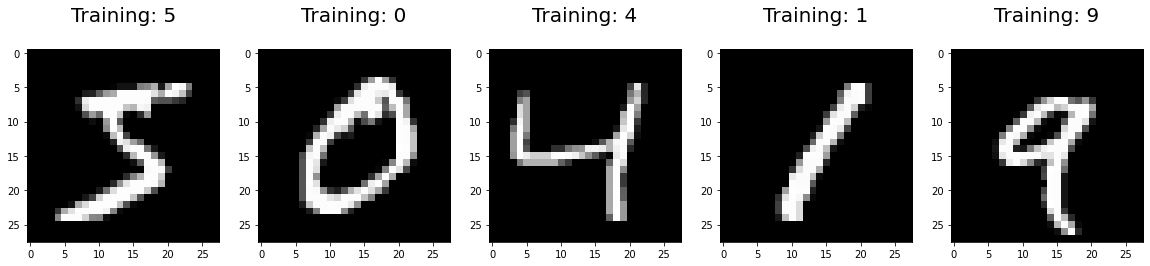

In [ ]:
plt.figure(figsize=(20,4))
for index, (image, label) in enumerate(zip(train_img[0:5], train_lbl[0:5])):
    plt.subplot(1, 5, index + 1)
    plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)
    plt.title('Training: %i\n' % label, fontsize = 20)



In [ ]:
from sklearn.linear_model import LogisticRegression 

# all parameters not specified are set to their defaults
# default solver is incredibly slow thats why we change it
logisticRegr = LogisticRegression(solver = 'lbfgs')

logisticRegr.fit(train_img, train_lbl)


# Returns a NumPy Array
# Predict for One Observation (image)
logisticRegr.predict(test_img[0].reshape(1,-1))


# Predict for Multiple Observations (images) at Once
logisticRegr.predict(test_img[0:10])

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


array([7, 2, 1, 0, 4, 1, 4, 9, 6, 9], dtype=uint8)

In [ ]:
score = logisticRegr.score(test_img, test_lbl)
print(score)

0.9255


In [ ]:
# Make predictions on test data
predictions = logisticRegr.predict(test_img)

In [ ]:
cm = metrics.confusion_matrix(test_lbl, predictions)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

In [ ]:
plt.figure(figsize=(9,9))
sns.heatmap(cm_normalized, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {:.3f}'.format(score) 
plt.title(all_sample_title, size = 15);

## Ahora hagamos modelos más complejos

### Divisiones
Antes de aprender, todos los algoritmos crean pares de división de funciones para todas las funciones. Ejemplos de estos pares son: (edad, <5), (edad, >10), (cantidad, >500). Estos pares de división de características se construyen en base a histogramas y se utilizan durante el aprendizaje como posibles divisiones de nodos. Este método de preprocesamiento es más rápido que el algoritmo voraz exacto, que enumera linealmente todas las divisiones posibles para las características continuas.

- lightGBM ofrece muestreo unilateral basado en gradientes (GOSS) que selecciona la división utilizando todas las instancias con gradientes grandes (es decir, error grande) y una muestra aleatoria de instancias con gradientes pequeños. Para mantener la misma distribución de datos al calcular la ganancia de información, GOSS introduce un multiplicador constante para las instancias de datos con gradientes pequeños. Por lo tanto, GOSS logra un buen equilibrio entre aumentar la velocidad al reducir la cantidad de instancias de datos y mantener la precisión de los árboles de decisión aprendidos. Este método no es el método predeterminado para LightGBM, por lo que debe seleccionarse explícitamente.
- Catboost ofrece una nueva técnica llamada Minimal Variance Sampling (MVS), que es una versión de muestreo ponderado de Stochastic Gradient Boosting. En esta técnica, el muestreo ponderado ocurre en el nivel de árbol y no en el nivel dividido. Las observaciones de cada árbol de refuerzo se muestrean de una manera que maximiza la precisión de la puntuación dividida.
- XGboost no utiliza ninguna técnica de muestreo ponderado, lo que hace que su proceso de división sea más lento en comparación con GOSS y MVS.

![fig](https://miro.medium.com/max/1400/1*E006sjlIjabDJ3jNixRSnA.png)

### Crecimiento de la hoja
- Catboost crece un árbol equilibrado. En cada nivel de dicho árbol, se selecciona el par característica-división que genera la pérdida más baja (según una función de penalización) y se utiliza para todos los nodos del nivel. Es posible cambiar su política utilizando el parámetro de política de crecimiento .
- LightGBM utiliza el crecimiento de árboles por hojas (lo mejor primero). Elige hacer crecer la hoja que minimice la pérdida, permitiendo un crecimiento de un árbol desequilibrado. Debido a que no crece por niveles, sino por hojas, el sobreajuste puede ocurrir cuando los datos son pequeños. En estos casos, es importante controlar la profundidad del árbol.
- XGboost se divide hasta el hiperparámetro max_ depth especificado y luego comienza a podar el árbol hacia atrás y elimina las divisiones más allá de las cuales no hay ganancia positiva. Utiliza este enfoque ya que a veces una división sin reducción de pérdidas puede ser seguida por una división con reducción de pérdidas. XGBoost también puede realizar el crecimiento de árboles por hojas (como LightGBM).




![fig](https://miro.medium.com/max/1400/1*A0b_ahXOrrijazzJengwYw.png)


In [ ]:
train_img.shape, train_lbl.shape

((60000, 784), (60000,))

Uso PCA para reducir la dimensionalidad

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=80)
pca.fit(train_img)

print(pca.explained_variance_ratio_)
print(pca.singular_values_)


[0.09704664 0.07095924 0.06169089 0.05389419 0.04868797 0.04312231
 0.0327193  0.02883895 0.02762029 0.02357001 0.0210919  0.02022991
 0.01715818 0.01692111 0.01578641 0.01482953 0.01324561 0.01276897
 0.01187263 0.01152684 0.01066166 0.01006713 0.00953573 0.00912544
 0.00883405 0.00839319 0.00812579 0.00786366 0.00744733 0.00690859
 0.00658094 0.00648148 0.00602615 0.00586582 0.00570021 0.00543627
 0.00505786 0.00487858 0.00481429 0.00472264 0.00456746 0.00444833
 0.00418499 0.00398214 0.00384966 0.00375095 0.00361986 0.00351563
 0.00340025 0.00321857 0.00319    0.00312741 0.00295937 0.00288887
 0.00284101 0.00271247 0.00269453 0.00258218 0.00253691 0.00244543
 0.00239686 0.00239194 0.00230056 0.00221305 0.00213294 0.00206546
 0.00202467 0.00196042 0.00191734 0.00187793 0.00186053 0.001794
 0.0017591  0.0017125  0.0016191  0.00160046 0.00159001 0.00151299
 0.00144885 0.0014106 ]
[141291.00226882 120817.18859621 112650.9232813  105291.96728785
 100077.18497144  94183.59653123  82040.11

In [ ]:
train_img_pca = pca.transform(train_img)

In [ ]:
sum(pca.explained_variance_ratio_)

0.8902130484772627

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_img_pca, train_lbl, test_size=0.33, random_state=42)

In [ ]:
X_train.shape, X_test.shape

((40200, 80), (19800, 80))

In [ ]:
lr = LogisticRegression(solver = 'lbfgs')

dt = DecisionTreeClassifier(max_depth=12, random_state=1234)

rf = RandomForestClassifier(n_estimators=500,
                            max_features=0.06,
                            n_jobs=6,
                            random_state=1234)

base_estim = DecisionTreeClassifier(max_depth=1, max_features=0.06)                            
ab = AdaBoostClassifier(base_estimator=base_estim,
                        n_estimators=500,
                        learning_rate=0.5,
                        random_state=1234)


gbm = GradientBoostingClassifier(n_estimators=2000,
                                 learning_rate=0.5,
                                 subsample=0.67,
                                 max_features=0.06,
                                 validation_fraction=0.1,
                                 n_iter_no_change=15,
                                 verbose=0,
                                 random_state=1234)

xgb = XGBClassifier(n_estimators=2000,
                    tree_method='hist',
                    subsample=0.67,
                    colsample_level=0.06,
                    verbose=0,
                    n_jobs=6,
                    random_state=1234)

lgbm = LGBMClassifier(n_estimators=2000,
                      feature_fraction=0.06,
                      bagging_fraction=0.67,
                      bagging_freq=1,
                      verbose=0,
                      n_jobs=6,
                      random_state=1234)

cb = CatBoostClassifier(n_estimators=2000,
                        colsample_bylevel=0.06,
                        max_leaves=31,
                        subsample=0.67,
                        verbose=0,
                        thread_count=6,
                        random_state=1234)



In [ ]:
models = [lr, dt, rf, ab, gbm, xgb, lgbm, cb]
model_names = [i.__class__.__name__ for i in models]

In [ ]:
es_models = ['XGBClassifier',
             'LGBMClassifier',
             'CatBoostClassifier']

In [ ]:
for m, n in zip(models, model_names):
    print(n)
    start_time = time()
    if n in es_models:
        m.fit(X_train,
              y_train,
              eval_set = [(X_test, y_test)],
              early_stopping_rounds=15,
              verbose=0)
    else:
        m.fit(X_train, y_train)
    
    run_time = time() - start_time
    accuracy = np.mean(m.predict(X_test) == y_test)
    print(accuracy, run_time)
    df_results.loc[n] = [accuracy, run_time]
    
    del m

DecisionTreeClassifier
0.8183333333333334 7.334710359573364
RandomForestClassifier
0.9531818181818181 98.67947173118591
AdaBoostClassifier
0.8074242424242424 37.948325872421265
GradientBoostingClassifier
